In [216]:
import pandas as pd
import numpy as np
import snorkel
import matplotlib.pyplot as plt
from snorkel.labeling import labeling_function
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel
import seaborn as sns

In [217]:
# read in the training data
df_train = pd.read_csv("data/training_set_seattle.csv")
df_train.head()

# read in gt.csv file
df_test = pd.read_csv('data/test_set_seattle.csv')

#select only label_type = curb ramp
# df_test = df_test[df_test['label_type'] == 'CurbRamp']

Y_test = df_test.verified.values

In [218]:
df_train['tag_list'].value_counts()


0.0    90151
1.0    88812
Name: tag_list, dtype: int64

In [219]:
df_test['tag_list'].value_counts()

1.0    9771
0.0    6809
Name: tag_list, dtype: int64

In [220]:
df_train['description'].value_counts()

0.0    176962
1.0      2001
Name: description, dtype: int64

In [198]:
df_test['description'].value_counts()

0.0    16301
1.0      279
Name: description, dtype: int64

In [223]:
#find the number of nan values in severity
np.isnan(df_test['severity']).sum()
# df_test['severity'].value_counts()
#convert all NaN values to 0
df_train['severity'] = df_train['severity'].fillna(0)
df_test['severity'] = df_train['severity'].fillna(0)

<AxesSubplot:>

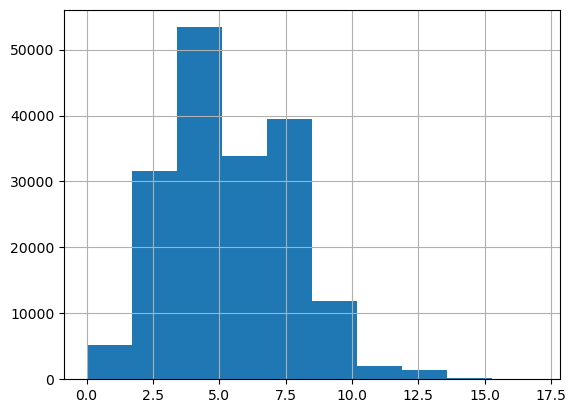

In [224]:
#plot count histogram
df_train['count'].hist()

(0.0, 50.0)

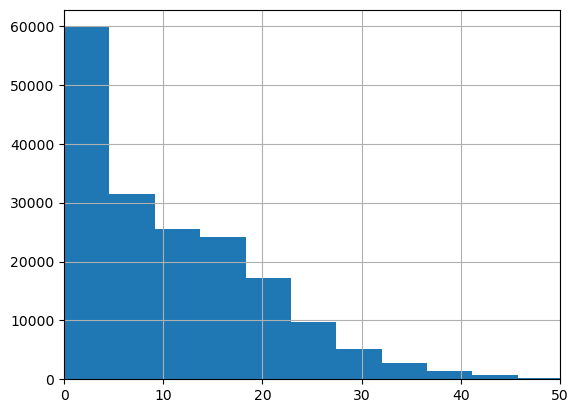

In [225]:
# df_train['distance'].hist()

#zoom in to x axis = 0-100
df_train['distance'].hist(bins=100)

plt.gca().set_xlim([0, 50])

Labeling Functions

In [279]:
# Define the label mappings for convenience
NOT_SURE = -1
WRONG = 0
CORRECT = 1

#check if it is in the curb false positive list
@labeling_function()
def intersection(x):
    # x in this case is a row of the dataframe
    return WRONG if x["false_positive"] == 1 else NOT_SURE

#check if the label is in the cluster
@labeling_function()
def clustered(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['count'] >= 5 else NOT_SURE
    # if x['count'] <= 2.5:
    #     return WRONG
    # elif x["count"] >= 5:
    #     return CORRECT
    # else:
    #     return NOT_SURE

#check if it is a severity 4 or higher
@labeling_function()
def severity(x):
    # x in this case is a row of the dataframe
    return CORRECT if x["severity"] >= 4 else NOT_SURE
    # return CORRECT if x["severity"] >= 5 else NOT_SURE

#check if the user zoomed in
@labeling_function()
def zoom(x):
    # x in this case is a row of the dataframe
    if x["zoom"] > 2:
        return CORRECT
    elif x["zoom"] == 1:
        return WRONG
    else:
        return NOT_SURE

#check if the user has put a tag
@labeling_function()
def tags(x):
    # x in this case is a row of the dataframe
    # return WRONG if (x['tag_list'] == 0 and x['description'] == 0) else NOT_SURE
    return CORRECT if x['tag_list'] == 1 else NOT_SURE

#check if the user has put a comment
@labeling_function()
def description(x):
    # x in this case is a row of the dataframe
    return CORRECT if x['description'] == 1 else NOT_SURE

#check for distance to the curb
@labeling_function()
def distance(x):
    # x in this case is a row of the dataframe
    return WRONG if x['distance'] >= 10 else NOT_SURE

In [280]:
lfs = [
    intersection, 
    clustered,
    severity,
    zoom,
    tags, 
    description,
    distance
    ]

In [281]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 16580/16580 [00:00<00:00, 23753.27it/s]


In [282]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
intersection,0,[0],0.046959,0.045685,0.031766
clustered,1,[1],0.681398,0.646776,0.538022
severity,2,[1],0.275085,0.274096,0.244922
zoom,3,"[0, 1]",0.784548,0.705939,0.585350
tags,4,[1],0.496259,0.486402,0.394277
description,5,[1],0.011181,0.011030,0.008650
distance,6,[0],0.462710,0.453217,0.413924


In [283]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [284]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.598]
INFO:root:[100 epochs]: TRAIN:[loss=0.008]
 37%|███▋      | 183/500 [00:00<00:00, 1816.71epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.007]
INFO:root:[300 epochs]: TRAIN:[loss=0.006]
100%|██████████| 500/500 [00:00<00:00, 1849.95epoch/s]
INFO:root:Finished Training


In [285]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   64.3%
Label Model Accuracy:     76.5%


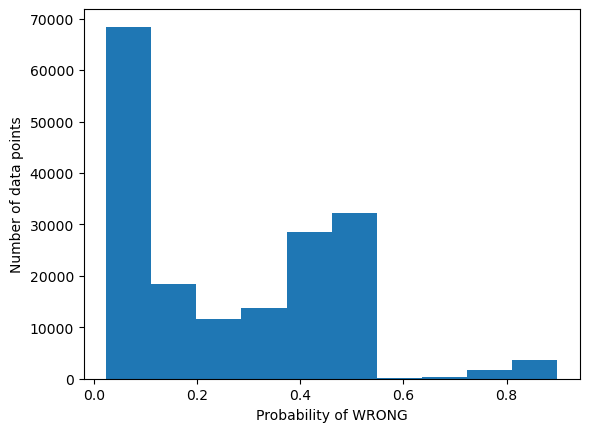

In [286]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of WRONG")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, WRONG])

Filtering out unlabeled data points

In [287]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [288]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [289]:
from sklearn.neural_network import MLPClassifier # Import MLPClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [301]:
# sklearn_model.fit(X=df_train_filtered, y=preds_train_filtered)

feature_cols = ['false_positive', 'count', 'severity', 'zoom', 'tag_list', 'distance', 'description']
X_train = df_train_filtered[feature_cols] # Features
y_train = preds_train_filtered # Target variable

# X_train, X_test_check, y_train, y_test_check = train_test_split(X_train, y_train, test_size=0.1) # 70% training and 30% test

clf = MLPClassifier(hidden_layer_sizes=(5,), max_iter=10, alpha=1e-4, activation = 'logistic', solver='adam', random_state=1, early_stopping=True).fit(X_train,y_train)

c:\Users\44549\anaconda3\envs\cse446\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [302]:
X_test = df_test[feature_cols]

y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.7714113389626055


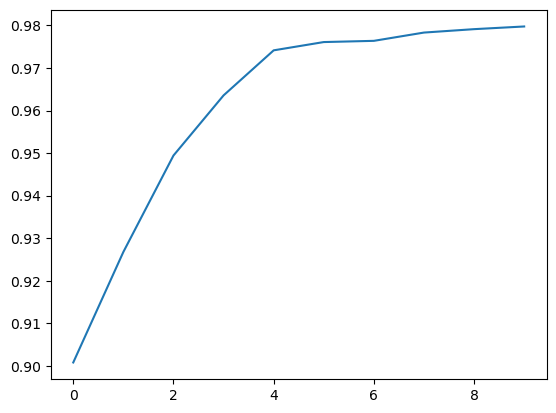

In [303]:
plt.plot(clf.validation_scores_)